# Deep Deterministic Policy Gradients (DDPG)
---
In this notebook, we train DDPG with OpenAI Gym's Pendulum-v0 environment.

### 1. Import the Necessary Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gym
import random
import torch
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
import datetime as dt

%matplotlib inline

from ddpg_agent import Agent

In [3]:
import os
import sys

repo_path = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
repo_path
sys.path.append(repo_path)

### 2. Instantiate the Environment and Agent

In [4]:
env = gym.make('Pendulum-v0')
env.seed(2)
agent = Agent(state_size=3, action_size=1, random_seed=2)

In [5]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
print('State shape: ', state_size)
print('Number of actions: ', state_size)

State shape:  3
Number of actions:  3


In [6]:
env.action_space.low, env.action_space.high

(array([-2.], dtype=float32), array([2.], dtype=float32))

In [ ]:
num_agents = 1
experiences = []
t_step = 0
scores = np.zeros(num_agents)  
scores_hist = np.zeros((0, num_agents))
scores_window = deque(maxlen=100)
    
# watch an untrained agent
states = env.reset()
while True:
    actions = agent.act(states)
    states, rewards, dones, _ = env.step(actions)
    experiences.append((states, actions, rewards))
    scores += rewards
    t_step += 1
    if np.any(dones):
        scores_hist = np.vstack([scores_hist, scores])
        scores_window.append(scores)
        break 
        

In [ ]:
t_step, scores, np.mean(scores_hist), np.mean(scores_window)

In [ ]:
states = env.reset()
t_step = 0
scores = np.zeros(num_agents)  

while True:
    actions = agent.act(states)
    states, rewards, dones, _ = env.step(actions)
    experiences.append((states, actions, rewards))
    scores += rewards
    t_step += 1
    if np.any(dones):
        scores_hist = np.vstack([scores_hist, scores])
        scores_window.append(scores)
        break 
        

In [ ]:
t_step, scores, np.mean(scores_hist), np.mean(scores_window)

### 3. Train the Agent with DDPG

In [7]:
from src.ac_agent import AgentDDPG, GaussianProcess, OUNoise
from ddpg_train import train

In [8]:
def action_scaler(actions):
    """Clips action values between -1 and 1"""
    
    return np.clip(actions, -1, 1)

In [9]:
RND_SEED = 123
num_agents = 1

In [11]:
ou_noise = OUNoise(num_agents, RND_SEED)

In [12]:
ddpg_agent = AgentDDPG(
    state_size=state_size, action_size=action_size, gamma=0.99,
    actor_hidden_layers=(400, 300), critic_hidden_layers=(400, 300), actor_add_bn=(False), critic_add_bn=(False),
    batch_size=128, learning_rates=(1e-4, 1e-3), grad_clipping=(False, False), weight_decay=(0, 1e-2),
    soft_upd_param=1e-3, update_every=1, buffer_size=int(1e5),
    noise=ou_noise, learn_every=1, learn_num=1,
    seed=RND_SEED, action_dtype='float')

In [13]:
path_ddpg_agent = os.path.join('models','ddpg0')

scores_ddpg = train(
    env, ddpg_agent, n_episodes=2000, max_t=200, solved=-50, action_scaler_fn=action_scaler,
    add_noise=True, noise_decay=1., min_noise_weight=1.,
    model_save_path=path_ddpg_agent)

Episode [100/2000]	Average score: -1,227.08
Episode [200/2000]	Average score: -831.83
Episode [300/2000]	Average score: -455.95
Episode [400/2000]	Average score: -387.48
Episode [500/2000]	Average score: -368.40
Episode [600/2000]	Average score: -451.75
Episode [700/2000]	Average score: -457.64
Episode [800/2000]	Average score: -417.64
Episode [900/2000]	Average score: -370.79
Episode [1000/2000]	Average score: -352.11
Episode [1100/2000]	Average score: -429.61
Episode [1200/2000]	Average score: -559.56
Episode [1300/2000]	Average score: -477.80
Episode [1400/2000]	Average score: -435.11
Episode [1500/2000]	Average score: -491.54
Episode [1600/2000]	Average score: -529.28
Episode [1700/2000]	Average score: -577.63
Episode [1800/2000]	Average score: -623.61
Episode [1900/2000]	Average score: -626.15
Episode [2000/2000]	Average score: -585.16


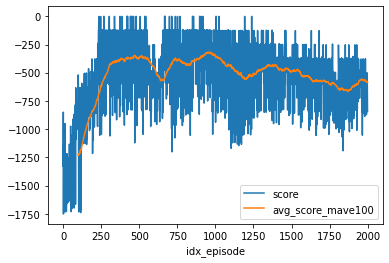

In [21]:
scores_ddpg.plot(y=['score', 'avg_score_mave100'])
plt.show()

In [15]:
scores_ddpg['experiment'] = 'ddpg:v00'


In [16]:
checkpoint_metadata = pd.Series(index=['N_episodes', 'gamma', 'actor_hidden_layers', 'critic_hidden_layers',
                'grad_clipping', 'batch_size', 'learning_rates',
                'soft_upd_param', 'update_every', 'buffer_size', 'noise', 'solved',
                'checkpoint_folder'],
         data = [len(scores_ddpg), 0.99, [400, 300], [400, 300], 
                 (0, 1.), 128, (1e-3, 1e-3), 1e-3, 4, int(1e5), 'ou-noise', True, 'ddpg0'], name='experiment:ddpg:v00')
checkpoint_metadata

N_episodes                        2000
gamma                             0.99
actor_hidden_layers         [400, 300]
critic_hidden_layers        [400, 300]
grad_clipping                 (0, 1.0)
batch_size                         128
learning_rates          (0.001, 0.001)
soft_upd_param                   0.001
update_every                         4
buffer_size                     100000
noise                         ou-noise
solved                            True
checkpoint_folder                ddpg0
Name: experiment:ddpg:v00, dtype: object

In [17]:
experiment_dt = dt.datetime.strftime(dt.datetime.now(), "%Y%m%d%H%M%S")

In [18]:
checkpoint_metadata.to_json(f'models/experiments/hparams_{experiment_dt}.json')
scores_ddpg.to_csv(f'models/experiments/scores_{experiment_dt}.csv')